<a href="https://colab.research.google.com/github/joshuajhchoi/ai2learn/blob/master/FRAUD_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## General information

In this kernel I work with IEEE Fraud Detection competition.

EEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry, and now you are invited to join the challenge.

We have a binary classification problem with a heavy imbalance which is an inherent property of such problems. The data is quite big and a lot of columns are anomynimized.

![](https://cis.ieee.org/images/files/slideshow/abstract01.jpg)

In [1]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

pd.options.display.precision = 15
from IPython.display import display
import warnings

warnings.filterwarnings("ignore")

import datetime
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb
%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

%load_ext autoreload
%autoreload 2


In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

seed = 42
seed_everything(seed)

## Data overview

At first we will load the data and have a look at it

In [3]:
# %%time
# folder_path = 'data/'
# train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
# train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
# test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
# test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
# sub = pd.read_csv(f'{folder_path}sample_submission.csv')

from google.colab import files
uploaded = files.upload()


Saving sample_submission.csv to sample_submission.csv
Saving test_identity.csv to test_identity.csv
Saving test_transaction.csv to test_transaction.csv
Saving train_identity.csv to train_identity.csv
Saving train_transaction.csv to train_transaction.csv


In [4]:
import io
train_identity = pd.read_csv(io.BytesIO(uploaded['train_identity.csv']))
train_transaction = pd.read_csv(io.BytesIO(uploaded['train_transaction.csv']))
test_identity = pd.read_csv(io.BytesIO(uploaded['test_identity.csv']))
test_transaction = pd.read_csv(io.BytesIO(uploaded['test_transaction.csv']))
sub = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))

In [5]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
train_identity.shape

(144233, 41)

In [7]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [8]:
train_transaction.shape

(590540, 394)

In [9]:
test_identity.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [10]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.949999999999999,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000000000000,47.950000762939453,0.000000000000000,0.000000000000000,47.950000762939453,0.000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000000000000,47.950000762939453,0.000000000000000,0.000000000000000,47.950000762939453,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000000000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,T,F,F,M0,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0

We can see that the data consists of the two parts: identity and transaction.

Identity contains ~40 columns, most of which are anonimized.
But still we can see information about device of the user: OS, browser version, resolution, type and some other things

Transaction data has almost 400 columns!

Some notable columns:

* card information
* transaction date and amount
* e-mail

First of all let's merge the data

In [11]:
# test columns have different names for some reason
test_identity.columns = [col.replace('-', '_') for col in test_identity.columns]

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [12]:
del train_transaction, train_identity, test_transaction, test_identity

In [13]:
test[[f'C{i}' for i in range(1,15)]] = test[[f'C{i}' for i in range(1,15)]].fillna(0)

Now let's see how much RAM does the data take.

In [14]:
end_mem = train.memory_usage().sum() / 1024 ** 2 + test.memory_usage().sum() / 1024 ** 2
print(f'Mem. usage {end_mem:5.2f} Mb')

Mem. usage 3637.61 Mb


This is a lot! But there is a method to decrease the RAM usage - it changes type of data columns, which making sure we don't loose any information.

In [15]:
def reduce_mem_usage(memory_df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = memory_df.memory_usage().sum() / 1024 ** 2
    for col in memory_df.columns:
        col_type = memory_df[col].dtypes
        if col_type in numerics:
            c_min = memory_df[col].min()
            c_max = memory_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    memory_df[col] = memory_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    memory_df[col] = memory_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    memory_df[col] = memory_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    memory_df[col] = memory_df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    memory_df[col] = memory_df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    memory_df[col] = memory_df[col].astype(np.float32)
                else:
                    memory_df[col] = memory_df[col].astype(np.float64)
    end_mem = memory_df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
            start_mem - end_mem) / start_mem))
    return memory_df

In [16]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


We decreased memory usage almost by 2/3.

## Data exploration

Let's start with identity information. id_01 - id_11 are continuous variables, id_12 - id_38 are categorical and the last two columns are obviously also categorical.

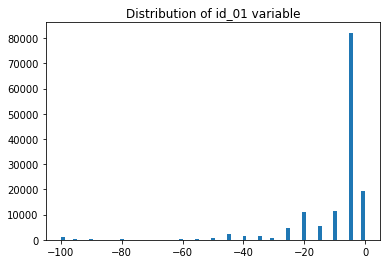

In [17]:
plt.hist(train['id_01'], bins=77);
plt.title('Distribution of id_01 variable');

`id_01` has an interesting distribution: it has 77 unique non-positive values with skeweness to 0.

In [18]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689233582822
0.0    0.108211128797372
1.0    0.001461374335354
3.0    0.001131168083449
2.0    0.000712906831036
Name: id_03, dtype: float64

`id_03` has 88% of missing values and 98% of values are either missing or equal to 0.

In [19]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

NaN         0.761272733430420
100.0000    0.225491922647069
95.0625     0.002111626646798
95.1875     0.001359772411691
97.1250     0.000956751447827
Name: id_11, dtype: float64

22% of values in `id_11` are equal to 100 and 76% are missing. Quite strange.

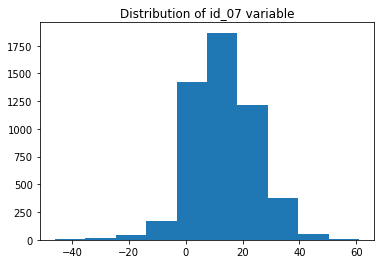

In [20]:
plt.hist(train['id_07']);
plt.title('Distribution of id_07 variable');

Some of features seem to be normalized. So if someone wants to normalize all variables, it would be necessary to separate such variables which seem to be already normalized.

Now let's have a look at transaction data.

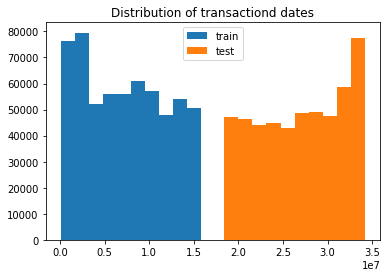

In [21]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

A very important idea: it seems that train and test transaction dates don't overlap, so it would be prudent to use time-based split for validation.

This was written in description:
```
The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).
```

People have analyses the data and have realized that start date is 2017-11-30. We will use this infomation later.

In [22]:
start_date = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

### Filling missing values in `card` columns

Сard columns are important but missing values.

In [23]:
for col in train.columns:
    if 'card' in col:
        print(f"{col} has {train[col].isnull().sum()} missing values.")

card1 has 0 missing values.
card2 has 8933 missing values.
card3 has 1565 missing values.
card4 has 1577 missing values.
card5 has 4259 missing values.
card6 has 1571 missing values.


Let's have a look at most common values of `card2` for each value of `card1`

In [24]:
group_with_mode = train.groupby(['card1']).agg({'card2': ['nunique', pd.Series.mode]})
group_with_mode.head(10)

card2     
      nunique mode
card1             
1000        1  555
1001        1  555
1004        1  583
1005        1  543
1006        1  399
1007        1  555
1008        1  555
1009        1  399
1010        1  555
1011        1  543

In [25]:
non_one = group_with_mode[group_with_mode['card2']['nunique'] > 1].shape[0]
card1_nunique = train['card1'].nunique()
print(f'Number of unique values of card1: {card1_nunique}')
print(f'Number of unique values of card1 which have more than one unique value: {non_one}')

Number of unique values of card1: 13553
Number of unique values of card1 which have more than one unique value: 248


We can see than in most cases for each value of `card1`, column `card2` has only 1 unique value. Let's use this to fill in missing values.

In [26]:
for card in ['card2','card3','card4','card5','card6']:
    group_with_mode = train.groupby(['card1']).agg({card: ['nunique', pd.Series.mode]})
    to_merge = group_with_mode[group_with_mode[card]['nunique'] == 1][card]['mode']
    merged = pd.merge(train['card1'], to_merge, on='card1', how='left')
    merged['mode'] = merged['mode'].fillna(train[card])
    train[card] = merged['mode']
    
    group_with_mode = test.groupby(['card1']).agg({card: ['nunique', pd.Series.mode]})
    to_merge = group_with_mode[group_with_mode[card]['nunique'] == 1][card]['mode']
    merged = pd.merge(test['card1'], to_merge, on='card1', how='left')
    merged['mode'] = merged['mode'].fillna(test[card])
    test[card] = merged['mode']

## Target and users

You can see information about labelling logic here: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#588953
```
The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) and transactions posterior to it with either user account, email address or billing address directly linked to these attributes as fraud too. If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0).
```

This is very important because as a result we can see that in case of the fraud, not only a single transaction is considered to be fraud, but also other transactions by the user are considered to be fraud.

But we don't have a column with the user id in the data - it was anonymized. As a result we can try to create user id column based on the other columns - for example a combination of address and card information could be used as an id.

People have realized that `D1` means the number of days since the first transaction by the user.

In [27]:
for df in [train,test]:
    df['DaysFromStart'] = np.floor(df['TransactionDT']/(60*60*24)) - 1
    df['D1-DaysFromStart'] = df['D1'] - df['DaysFromStart']

In [28]:
for df in [train,test]:
    df['uid'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card3'].astype(str) + '_' + df['card4'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card5'].astype(str) + '_' + df['card6'].astype(str)
    df['uid'] = df['uid'] + '_' + df['addr1'].astype(str) + '_' + df['D1-DaysFromStart'].astype(str)

In [29]:
len(set(train['uid']).intersection(set(test['uid']))), train.uid.nunique(), test.uid.nunique()

(26891, 231339, 205162)

We can see that only some uids overlap between train and test data. This means we can't directly use this feature, we should create various features based on it.

### processing some device information and ids

In [30]:
train['DeviceInfo'].value_counts(dropna=False, normalize=True).head(20)

NaN                            0.799055102109933
Windows                        0.080810783350831
iOS Device                     0.033498154231720
MacOS                          0.021290683103600
Trident/7.0                    0.012598638534223
rv:11.0                        0.003219087614726
rv:57.0                        0.001629017509398
SM-J700M Build/MMB29K          0.000929657601517
SM-G610M Build/MMB29K          0.000780641446811
SM-G531H Build/LMY48B          0.000694279811698
rv:59.0                        0.000612998272767
SM-G935F Build/NRD90M          0.000565584041725
SM-G955U Build/NRD90M          0.000555423849358
SM-G532M Build/MMB29T          0.000535103464626
ALE-L23 Build/HuaweiALE-L23    0.000528330003048
SM-G950U Build/NRD90M          0.000491075964372
SM-G930V Build/NRD90M          0.000463982118061
rv:58.0                        0.000455515291090
rv:52.0                        0.000433501540963
SAMSUNG                        0.000397940867680
Name: DeviceInfo, dt

In [31]:
train['DeviceInfo'].nunique()

1786

There are a lot of different devices! And in most cases device is unknown. Let's fix this and create some features

In [32]:
for df in [train, test]:
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))

In [33]:
df['DeviceInfo_device'].value_counts(dropna=False, normalize=True).head(20)

unknowndevice          0.772924721378513
windows                0.088787841110262
iosdevice              0.036945594060285
macos                  0.022003548513788
trident                0.009650852294594
rv                     0.005549733466748
smgu                   0.001569003593906
smgmbuildmmbt          0.001310463379061
motog                  0.001036134448806
smgf                   0.001018372143969
smjm                   0.000972979587165
smgfbuildrnw           0.000943375745770
smgm                   0.000937454977491
motogplus              0.000799303717650
samsungsmgubuildrnw    0.000785488591666
smgubuildrnw           0.000742069624288
smgmbuildmmbk          0.000724307319451
motogplay              0.000722333730025
motoebuildnma          0.000712465782893
smaf                   0.000645363742399
Name: DeviceInfo_device, dtype: float64

In [34]:
df['DeviceInfo_version'].value_counts(dropna=False, normalize=True).head(20)

         0.923432624617370
70       0.009688350493693
3        0.002105819917859
53229    0.001722943569158
5        0.001636105634400
110      0.001482165659149
95016    0.001456508996607
610      0.001328225683898
4        0.001322304915619
33       0.001306516200209
950      0.001241387749141
6        0.001170338529794
0303     0.001091394952742
630      0.000935481388065
2        0.000894036010113
61029    0.000751937571419
03       0.000696677067483
70029    0.000696677067483
700      0.000672993994367
620      0.000661152457810
Name: DeviceInfo_version, dtype: float64

In [35]:
df['id_30'].value_counts(dropna=False, normalize=True).head(20)

NaN                 0.860548144727260
Windows 10          0.041474981793638
Windows 7           0.020462175171850
iOS 12.1.0          0.012530319267561
iOS 11.4.1          0.006982559390240
Mac OS X 10_13_6    0.006422059993171
Android 8.0.0       0.004845162041560
iOS 12.0.1          0.003337339719869
iOS 11.4.0          0.003167611029207
Mac OS X 10_11_6    0.002869599025836
Windows 8.1         0.002751183660258
Linux               0.002668292904354
Mac OS X 10_12_6    0.002615005989844
iOS 12.0.0          0.002476854730003
iOS 12.1.2          0.002384096026967
Mac OS X 10_14_1    0.002097925560154
Mac OS X 10_10_5    0.001823596629899
Android             0.001517690268823
Android 7.0         0.001385459777261
iOS 11.3.0          0.001274938769388
Name: id_30, dtype: float64

In [36]:
train['id_30'].nunique()

75

In [37]:
df['id_31'].value_counts(dropna=False, normalize=True).head(20)

NaN                        0.730358344632133
chrome 70.0                0.031684004649777
mobile safari 12.0         0.025850074305642
mobile safari 11.0         0.020193767009874
chrome 71.0                0.018727390066135
chrome 69.0                0.016366977112283
chrome 70.0 for android    0.015046645786091
chrome 68.0                0.012727678210191
chrome 67.0                0.012082314467792
chrome 69.0 for android    0.011884955525162
ie 11.0 for desktop        0.010209378102236
chrome 71.0 for android    0.009925181224849
edge 17.0                  0.009613354095494
chrome 67.0 for android    0.007175971154017
safari 12.0                0.007006242463355
chrome 68.0 for android    0.006947034780566
safari 11.0                0.005717488567983
firefox 63.0               0.003747846320539
samsung browser 7.4        0.002701843924601
firefox 61.0               0.002607111632139
Name: id_31, dtype: float64

Let's process these column similar to `DeviceInfo`.

In [38]:
for df in [train, test]:
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))

    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

### process some D-columns

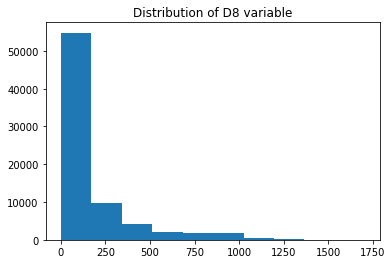

In [39]:
plt.hist(train['D8']);
plt.title('Distribution of D8 variable');

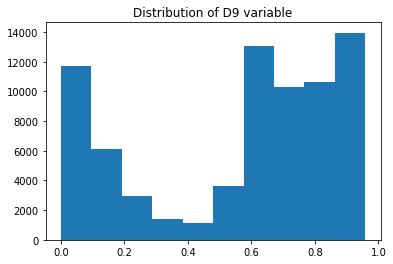

In [40]:
plt.hist(train['D9']);
plt.title('Distribution of D9 variable');

In [41]:
for df in [train, test]:
    # clip values
    for col in ['D'+str(i) for i in range(1,16)]:
        df[col] = df[col].clip(0)
    
    # separate column showing whether D9 is null or not
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    # separate column showing whether D8 is >=1 or not
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    # some clever feature engineering I saw in kernel
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

## Process `TransactionAmt`

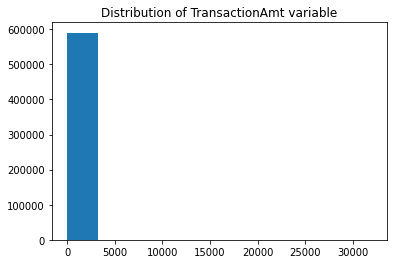

In [42]:
plt.hist(train['TransactionAmt']);
plt.title('Distribution of TransactionAmt variable');

In [43]:
np.percentile(train['TransactionAmt'], 99)

1104.0

In [44]:
# Clip Values
train['TransactionAmt'] = train['TransactionAmt'].clip(0,5000)
test['TransactionAmt']  = test['TransactionAmt'].clip(0,5000)

# Check if the Transaction Amount is common or not
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

Several more arbitraty features, which work

In [45]:
for df in [train, test]:
    df['ProductCD_card1'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str)
    df['card1_addr1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
    df['TransactionAmt_dist2'] = df['TransactionAmt'].astype(str) + '_' + df['dist2'].astype(str)
    df['card3_card5'] = df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['ProductCD_TransactionAmt'] = df['ProductCD'].astype(str) + '_' + df['TransactionAmt'].astype(str)
    df['cents'] = np.round(df['TransactionAmt'] - np.floor(df['TransactionAmt']), 3)
    df['ProductCD_cents'] = df['ProductCD'].astype(str) + '_' + df['cents'].astype(str)
    df['TransactionAmt'] = np.log1p(df['TransactionAmt'])


In [46]:
test['ProductCD_card1']

0         W_10409
1          W_4272
2          W_4476
3         W_10989
4         W_18018
           ...   
506686    C_13832
506687     C_3154
506688    W_16661
506689    W_16621
506690     C_5713
Name: ProductCD_card1, Length: 506691, dtype: object

In [47]:
# these features were useful only for creating other features
train = train.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)
test = test.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)

### Adding date based features

In [48]:
for df in [train, test]:
    # Temporary variables for aggregation
    df['DT'] = df['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))
    df['DT_M'] = ((df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear).astype(np.int16)

    df['DT_hour'] = df['DT'].dt.hour.astype(np.int8)
    df['DT_day_week'] = df['DT'].dt.dayofweek.astype(np.int8)
    df['DT_day_month'] = df['DT'].dt.day.astype(np.int8)

    # Possible solo feature
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december'] == 12).astype(np.int8)


## Validation

Correct validation is extremely important. If your local score correlates with leaderboard score, then you can train and compare model locally and submit only from time to time. If your local score doesn't correlate with leaderboard score, you can't really estimate whether your models are good or not.

We have dates in our data, so we have to use some kind of time-series validation - this means that our training data should be always before validation data.

In this kernel I'll simply take first 80% data for training and last 20% for validation. To ensure robustness I'll train several models with different random seeds and average the score.

In [49]:
y = train['isFraud']
X = train.drop(['isFraud'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [50]:
# free memory
del train
import gc
gc.collect()

24087

### Processing the data separately

To ensure our validation is correct, we have to process train and validation data exactly as train and test data. To do it I'll write functions, which will process two dataframes.

In this function among other things I'll create a list `remove_features` which will contain features, which won't be used in modelling. Some of them were only temporary, some others were proved to be useless or bad.

First of all let's write a function for frequency encoding. It takes two dataframes, combines one column from these dataframes and calculated the counts of each category in it. This will be used to create a new column with these values instead of categories. This is a widely used kaggle technic.

In [51]:
def freq_encode_full(df1, df2, col, normalize=True):
    """
    Encode

    https://www.kaggle.com/cdeotte/high-scoring-lgbm-malware-0-702-0-775
    """
    df = pd.concat([df1[col], df2[col]])
    freq_dict = df.value_counts(dropna=False, normalize=normalize).to_dict()
    col_name = col + '_freq_enc_full'
    return col_name, freq_dict

In [52]:
def process_data(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # copy them so that they aren't changed inplace
    train_df = df_train.copy()
    test_df = df_test.copy()
    remove_features = ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week',
                       'DT_day_month',
                       'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid',
                       'D5_DT_W_std_score',
                       'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score',
                       'D11_DT_W_std_score',
                       'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score',
                       'card3_card5_DT_D', 'ProductCD_cents_DT_D',
                       'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist',
                       'D10_DT_W_std_score', 'D8_DT_D_std_score',
                       'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score',
                       'ProductCD_TransactionAmt']

    """
    The following piece of code does the following:
    * combine values of a certain column in train and test data, calculate `value_counts`
    * define `valid_card` as categories which have at least one value
    * if column category in train data is also in test data, then keep it, otherwise replace with None
    * if column category in train data is in `valid_card`, then keep it, otherwise replace with None
    * do the same for test data
    """
    for col in ['card1', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2']:
        valid_card = pd.concat([train_df[[col]], test_df[[col]]])
        valid_card = valid_card[col].value_counts()

        valid_card = valid_card[valid_card > 2]
        valid_card = list(valid_card.index)

        train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
        train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)

        test_df[col] = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)
        test_df[col] = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    # as before, if value is only on one dataset, replace is with None
    for col in ['card2', 'card3', 'card4', 'card5', 'card6']:
        train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
        test_df[col] = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    ####### Clip C-columns with max value in the last month in train data.
    i_cols = ['C' + str(i) for i in range(1, 15)]
    for df in [train_df, test_df]:
        for col in i_cols:
            max_value = train_df[train_df['DT_M'] == train_df['DT_M'].max()][col].max()
            df[col] = df[col].clip(None, max_value)

    ####### V feature - nan group agg
    # this will be a dictionary which contains number of null values and lists of columns
    nans_groups = {}
    nans_df = pd.concat([train_df, test_df]).isna()

    i_cols = ['V' + str(i) for i in range(1, 340)]
    for col in i_cols:
        # count of nan values
        cur_group = nans_df[col].sum()
        if cur_group > 0:
            try:
                nans_groups[cur_group].append(col)
            except:
                nans_groups[cur_group] = [col]

    for i, (n_group, n_cols) in enumerate(nans_groups.items()):
        for df in [train_df, test_df]:
            df[f'nan_group_{i}_sum'] = df[n_cols].sum(axis=1)
            df[f'nan_group_{i}_mean'] = df[n_cols].mean(axis=1)
            df[f'nan_group_{i}_std'] = df[n_cols].std(axis=1)

    del nans_groups, nans_df
    remove_features += i_cols
    # they take too much space
    i_cols = [i for i in i_cols if i not in ['V258', 'V306', 'V307', 'V308', 'V294']]
    train_df = train_df.drop(i_cols, axis=1)
    test_df = test_df.drop(i_cols, axis=1)

    # frequency encoding. Add encoded feature and add the original feature to list `remove_features`
    i_cols = [
        'ProductCD_TransactionAmt', 'ProductCD_cents', 'cents',
        'DeviceInfo', 'DeviceInfo_device', 'DeviceInfo_version',
        'id_30', 'id_30_device', 'id_30_version',
        'id_31', 'id_31_device',
        'id_33',
    ]
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    # frequency encoding while keeping original features
    i_cols = ['id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13',
              'id_14', 'id_17', 'id_18', 'id_19', 'id_20',
              'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'card1', 'card2', 'card3', 'card5', 'ProductCD_card1',
              'card1_addr1', 'TransactionAmt_dist2']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    return train_df, test_df, remove_features

In [53]:
%%time
X_train, X_val, remove_features = process_data(X_train, X_val)

CPU times: user 32.3 s, sys: 197 ms, total: 32.5 s
Wall time: 32.6 s


## Feature engineering

To start with let's do a very basic feature engineering (on the top of what we have done already) - do label encoding on categorical columns.

In [54]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    train_df = df_train.copy()
    test_df = df_test.copy()

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)

    feature_columns = [col for col in list(train_df) if col not in remove_features]
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    print(f'train.shape : {train_df[feature_columns].shape}, test.shape : {test_df[feature_columns].shape}')

    return train_df[feature_columns], test_df[feature_columns], categorical_features


In [55]:
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

## Training the model

Let's write a function to train the model and validate our approach.

Nowadays gradient boosting models are almost always best for tabular data. So we will use LightGBM.

In [56]:
lgb_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.01,
    'num_leaves': 2**8,
    'max_bin': 255,
    'max_depth': -1,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'bagging_seed': seed,
    'feature_fraction': 0.7,
    'feature_fraction_seed': seed,
    'first_metric_only': True,
    'verbose': 100,
    'n_jobs': -1,
    'seed': seed,
}

The competition metric is roc_auc. By default LightGBM calculates it quite slow, so we will write out custom evaluation function

In [57]:
@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_pred, y_true):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true.get_label(), y_pred), True


In [58]:
def make_val_prediction(X_train, y_train, X_val, y_val, seed=0, seed_range=3, lgb_params=None,
                        category_cols=None):
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    auc_scores = []
    best_iterations = []
    val_preds = np.zeros((X_val.shape[0], 3))

    feature_importance_df = pd.DataFrame()
    feature_importance_df['feature'] = X_train.columns.tolist()
    feature_importance_df['gain_importance'] = 0

    for i, s in enumerate(range(seed, seed + seed_range)):
        seed_everything(s)
        params = lgb_params.copy()
        params['seed'] = s
        params['bagging_seed'] = s
        params['feature_fraction_seed'] = s

        clf = lgb.train(params, train_data, 10000, valid_sets=[train_data, val_data],
                        categorical_feature=categorical_features,
                        early_stopping_rounds=500, feval=eval_auc, verbose_eval=200)

        best_iteration = clf.best_iteration
        best_iterations.append(best_iteration)
        val_pred = clf.predict(X_val, best_iteration)
        val_preds[:, i] = val_pred

        auc = fast_auc(y_val, val_pred)
        auc_scores.append(auc)
        print('seed:', s, ', auc:', auc, ', best_iteration:', best_iteration)

        feature_importance_df['gain_importance'] += clf.feature_importance('gain') / seed_range

    auc_scores = np.array(auc_scores)
    best_iterations = np.array(best_iterations)
    best_iteration = int(np.mean(best_iterations))

    avg_pred_auc = fast_auc(y_val, np.mean(val_preds, axis=1))
    print(
        f'avg pred auc: {avg_pred_auc:.5f}, avg auc: {np.mean(auc_scores):.5f}+/-{np.std(auc_scores):.5f}, avg best iteration: {best_iteration}')

    feature_importance_df = feature_importance_df.sort_values(by='gain_importance', ascending=False).reset_index(
        drop=True)
    plt.figure(figsize=(16, 12));
    sns.barplot(x="gain_importance", y="feature", data=feature_importance_df[:50])
    plt.title('LGB Features (avg over folds)');

    return feature_importance_df, best_iteration, val_preds


Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.960748	valid_1's auc: 0.906404
[400]	training's auc: 0.98665	valid_1's auc: 0.92361
[600]	training's auc: 0.9949	valid_1's auc: 0.929247
[800]	training's auc: 0.997966	valid_1's auc: 0.931926
[1000]	training's auc: 0.999141	valid_1's auc: 0.933006
[1200]	training's auc: 0.999648	valid_1's auc: 0.933653
[1400]	training's auc: 0.99986	valid_1's auc: 0.934071
[1600]	training's auc: 0.999941	valid_1's auc: 0.934269
[1800]	training's auc: 0.999976	valid_1's auc: 0.934395
[2000]	training's auc: 0.999991	valid_1's auc: 0.934247
[2200]	training's auc: 0.999997	valid_1's auc: 0.934248
Early stopping, best iteration is:
[1720]	training's auc: 0.999966	valid_1's auc: 0.934501
seed: 0 , auc: 0.9345014185193614 , best_iteration: 1720
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.96144	valid_1's auc: 0.905983
[400]	training's auc: 0.986417	valid_1's auc: 0.922384
[600]	trai

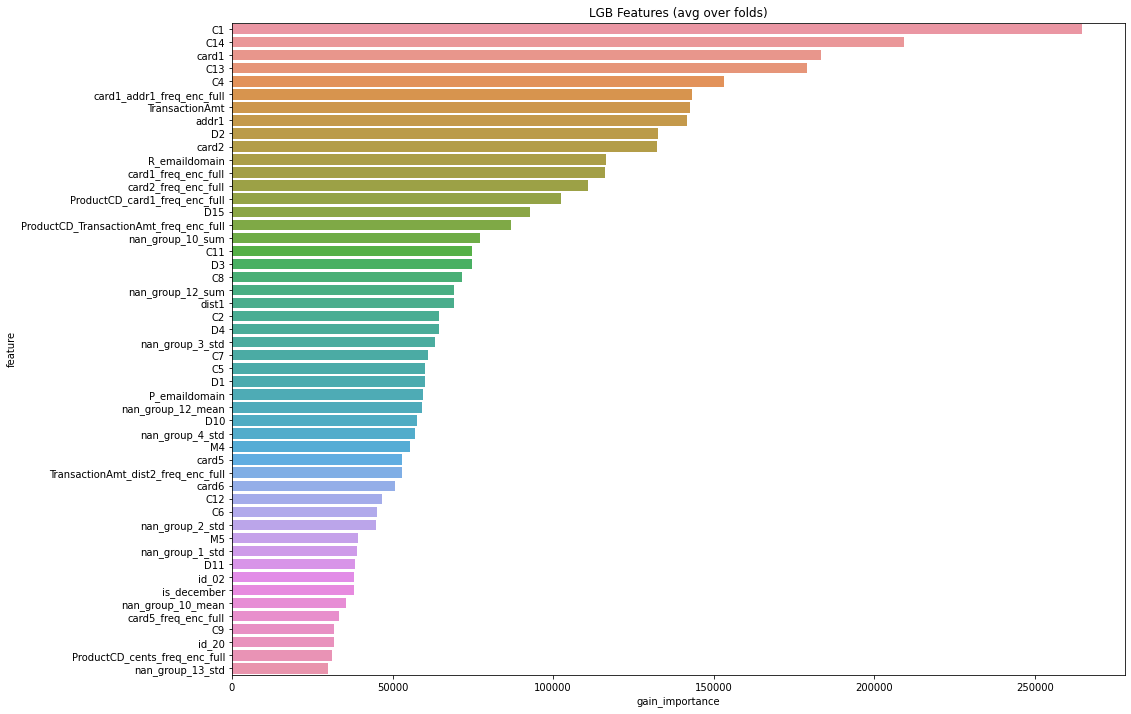

In [59]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

## Making prediction

And now we can try to make prediction.

We'll train models on the whole data on stratified folds. We won't use validation in the model, but we will set a fixed number of iterations to avoid overfitting.
Training will be done on folds.

In [60]:
def prediction(X, y, X_test, best_iteration, seed=seed, category_cols=None, n_folds=5):
    print('best iteration:', best_iteration)
    preds = np.zeros((X_test.shape[0], n_folds))

    print(X.shape, X_test.shape)

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    for i, (trn_idx, _) in enumerate(skf.split(X, y)):
        fold = i + 1

        tr_x, tr_y = X.iloc[trn_idx, :], y.iloc[trn_idx]

        tr_data = lgb.Dataset(tr_x, label=tr_y)

        clf = lgb.train(lgb_params, tr_data, best_iteration, categorical_feature=category_cols)
        preds[:, i] = clf.predict(X_test)

    return preds


In [61]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

In [62]:
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)

best iteration: 1725
(590540, 178) (506691, 178)


In [63]:
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_1.csv', index=False)

## More feature engineering

Now we will work more with D-columns

We will define a function, which will take some period (weeks or days), group by some value based on this period and then calculate normalized values - by min/max and by mean/std.

In [64]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period

            dt_df[col] = dt_df[col].astype(float)

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col + '_min_max'] = (dt_df[col] - dt_df['temp_min']) / (dt_df['temp_max'] - dt_df['temp_min'])
            dt_df[new_col + '_std_score'] = (dt_df[col] - dt_df['temp_mean']) / (dt_df['temp_std'])
            del dt_df['temp_min'], dt_df['temp_max'], dt_df['temp_mean'], dt_df['temp_std']
    return dt_df

In [65]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # copy them so that they aren't changed inplace
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    # normalize by max train value
    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    # frequency encoding
    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [66]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.961953	valid_1's auc: 0.904405
[400]	training's auc: 0.988424	valid_1's auc: 0.921098
[600]	training's auc: 0.996151	valid_1's auc: 0.927417
[800]	training's auc: 0.998798	valid_1's auc: 0.929791
[1000]	training's auc: 0.999589	valid_1's auc: 0.930964
[1200]	training's auc: 0.999877	valid_1's auc: 0.931759
[1400]	training's auc: 0.999963	valid_1's auc: 0.932069
[1600]	training's auc: 0.999989	valid_1's auc: 0.93233
[1800]	training's auc: 0.999996	valid_1's auc: 0.932607
[2000]	training's auc: 0.999999	valid_1's auc: 0.93267
[2200]	training's auc: 0.999999	valid_1's auc: 0.932661
[2400]	training's auc: 0.999999	valid_1's auc: 0.932697
Early stopping, best iteration is:
[2088]	training's auc: 0.999999	valid_1's auc: 0.932803
seed: 0 , auc: 0.9328093589447587 , best_iteration: 2088
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.962683	valid_1's auc: 0.904042
[400]

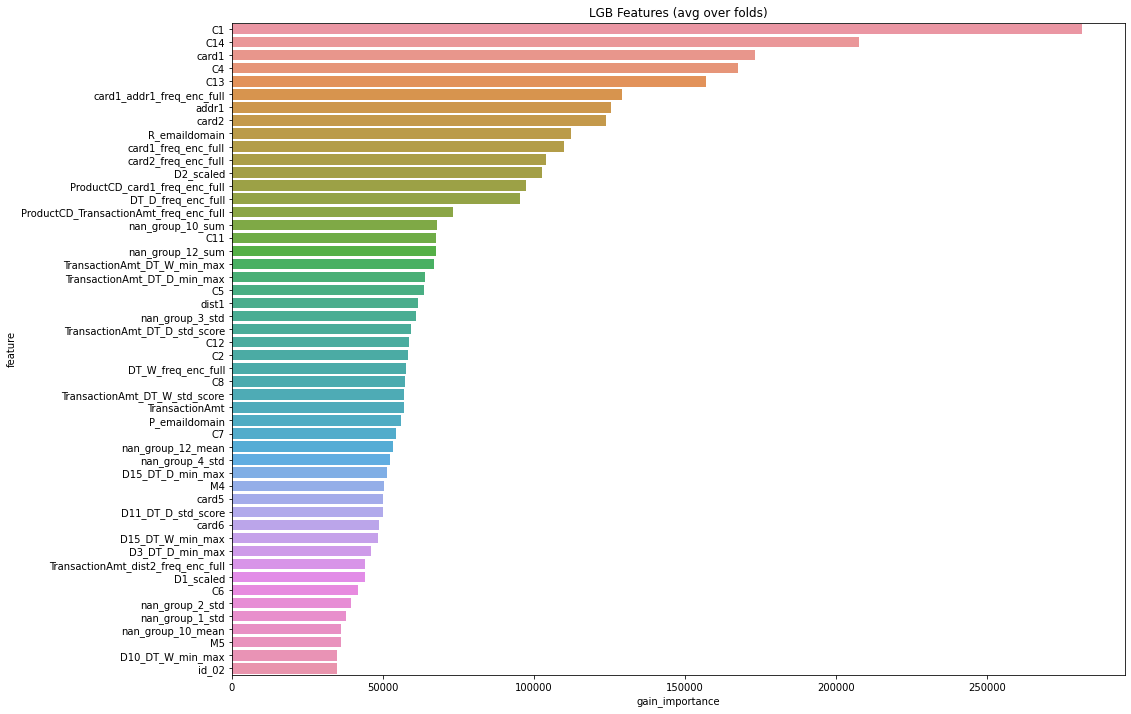

In [67]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [68]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_2.csv', index=False)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

## More feature engineering 2

Now we will work with C-columns

In [69]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # copy them so that they aren't changed inplace
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    # normalize by max train value
    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    # frequency encoding
    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]
    # this column count zero values in C columns
    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [70]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.96311	valid_1's auc: 0.906187
[400]	training's auc: 0.988597	valid_1's auc: 0.921637
[600]	training's auc: 0.996641	valid_1's auc: 0.927761
[800]	training's auc: 0.998963	valid_1's auc: 0.930136
[1000]	training's auc: 0.999677	valid_1's auc: 0.93129
[1200]	training's auc: 0.999903	valid_1's auc: 0.931916
[1400]	training's auc: 0.999972	valid_1's auc: 0.932539
[1600]	training's auc: 0.999992	valid_1's auc: 0.932614
[1800]	training's auc: 0.999997	valid_1's auc: 0.932671
[2000]	training's auc: 0.999999	valid_1's auc: 0.932636
[2200]	training's auc: 0.999999	valid_1's auc: 0.932807
[2400]	training's auc: 0.999999	valid_1's auc: 0.932791
[2600]	training's auc: 0.999999	valid_1's auc: 0.932803
Early stopping, best iteration is:
[2257]	training's auc: 0.999999	valid_1's auc: 0.933004
seed: 0 , auc: 0.9330028171368863 , best_iteration: 2257
Training until validation scores don't improve for 500 rounds.
[200

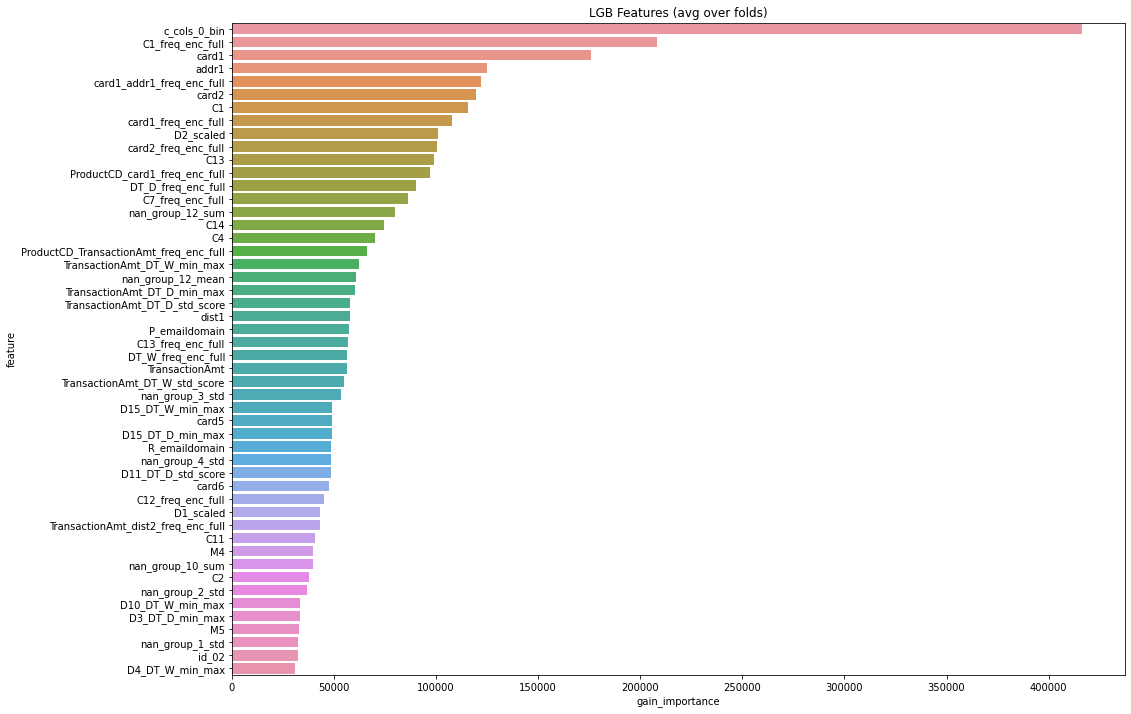

In [71]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [72]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_3.csv', index=False)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

## More feature engineering - aggregations

We will calculate various aggregations over the data.

In [73]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col + '_' + main_column + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                    columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)
    return train_df, test_df

In [74]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # copy them so that they aren't changed inplace
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]

    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    i_cols = ['TransactionAmt', 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_14', 'dist1'] + ['C' + str(i) for i in
                                                                                                  range(1, 15)]
    uids = ['card1', 'card2', 'card3', 'card5', 'uid', 'card3_card5']
    aggregations = ['mean', 'std']

    # uIDs aggregations
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = [
                 'V258',
                 'V306', 'V307', 'V308', 'V294'
             ] + ['D' + str(i) for i in range(1, 16)]
    uids = ['uid', 'card3_card5']
    aggregations = ['mean', 'std']
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [75]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.983308	valid_1's auc: 0.93145
[400]	training's auc: 0.997095	valid_1's auc: 0.942484
[600]	training's auc: 0.999443	valid_1's auc: 0.946304
[800]	training's auc: 0.999858	valid_1's auc: 0.947598
[1000]	training's auc: 0.999978	valid_1's auc: 0.948134
[1200]	training's auc: 0.999997	valid_1's auc: 0.948247
[1400]	training's auc: 0.999999	valid_1's auc: 0.948219
[1600]	training's auc: 1	valid_1's auc: 0.947993
Early stopping, best iteration is:
[1129]	training's auc: 0.999993	valid_1's auc: 0.94832
seed: 0 , auc: 0.9483196731017204 , best_iteration: 1129
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.9835	valid_1's auc: 0.930146
[400]	training's auc: 0.997091	valid_1's auc: 0.941364
[600]	training's auc: 0.999475	valid_1's auc: 0.945172
[800]	training's auc: 0.999891	valid_1's auc: 0.946702
[1000]	training's auc: 0.999979	valid_1's auc: 0.947183
[1200]	training's

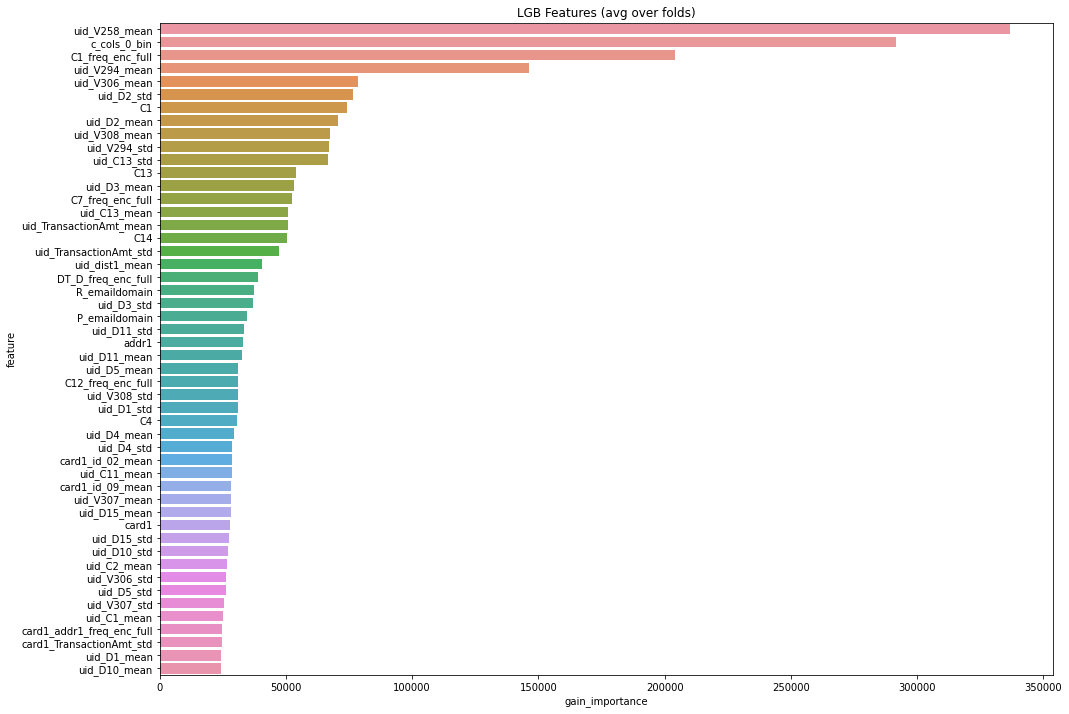

In [76]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [77]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_4.csv', index=False)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

## More feature engineering - time-brock frequency encoding

This is similar to usual frequency encoding, but we encode values within periods.

In [78]:
def timeblock_frequency_encoding(train_df, test_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period
            print('timeblock frequency encoding:', new_col)
            train_df[new_col] = train_df[col].astype(str) + '_' + train_df[period].astype(str)
            test_df[new_col] = test_df[col].astype(str) + '_' + test_df[period].astype(str)

            temp_df = pd.concat([train_df[[new_col]], test_df[[new_col]]])
            fq_encode = temp_df[new_col].value_counts(normalize=True).to_dict()

            train_df[new_col] = train_df[new_col].map(fq_encode)
            test_df[new_col] = test_df[new_col].map(fq_encode)

            train_df[new_col] = train_df[new_col] / train_df[period + '_freq_enc_full']
            test_df[new_col] = test_df[new_col] / test_df[period + '_freq_enc_full']

    return train_df, test_df

In [79]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # copy them so that they aren't changed inplace
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]

    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    i_cols = ['TransactionAmt', 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_14', 'dist1'] + ['C' + str(i) for i in
                                                                                                  range(1, 15)]
    uids = ['card1', 'card2', 'card3', 'card5', 'uid', 'card3_card5']
    aggregations = ['mean', 'std']

    # uIDs aggregations
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = [
                 'V258',
                 'V306', 'V307', 'V308', 'V294'
             ] + ['D' + str(i) for i in range(1, 16)]
    uids = ['uid', 'card3_card5']
    aggregations = ['mean', 'std']
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = ['ProductCD_TransactionAmt', 'ProductCD_cents', 'ProductCD_cents', 'uid', 'card3_card5']
    periods = ['DT_D', 'DT_W']
    train_df, test_df = timeblock_frequency_encoding(train_df, test_df, periods, i_cols)

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features


In [80]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

timeblock frequency encoding: ProductCD_TransactionAmt_DT_D
timeblock frequency encoding: ProductCD_cents_DT_D
timeblock frequency encoding: ProductCD_cents_DT_D
timeblock frequency encoding: uid_DT_D
timeblock frequency encoding: card3_card5_DT_D
timeblock frequency encoding: ProductCD_TransactionAmt_DT_W
timeblock frequency encoding: ProductCD_cents_DT_W
timeblock frequency encoding: ProductCD_cents_DT_W
timeblock frequency encoding: uid_DT_W
timeblock frequency encoding: card3_card5_DT_W
remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_s

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.983873	valid_1's auc: 0.931157
[400]	training's auc: 0.997067	valid_1's auc: 0.941687
[600]	training's auc: 0.999471	valid_1's auc: 0.945557
[800]	training's auc: 0.999864	valid_1's auc: 0.946938
[1000]	training's auc: 0.99998	valid_1's auc: 0.947581
[1200]	training's auc: 0.999997	valid_1's auc: 0.948081
[1400]	training's auc: 1	valid_1's auc: 0.948166
[1600]	training's auc: 1	valid_1's auc: 0.948142
[1800]	training's auc: 1	valid_1's auc: 0.94806
[2000]	training's auc: 1	valid_1's auc: 0.947918
Early stopping, best iteration is:
[1502]	training's auc: 1	valid_1's auc: 0.948226
seed: 0 , auc: 0.9481873638631533 , best_iteration: 1502
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.983487	valid_1's auc: 0.930244
[400]	training's auc: 0.997104	valid_1's auc: 0.941316
[600]	training's auc: 0.999476	valid_1's auc: 0.94476
[800]	training's auc: 0.999893	valid_1's au

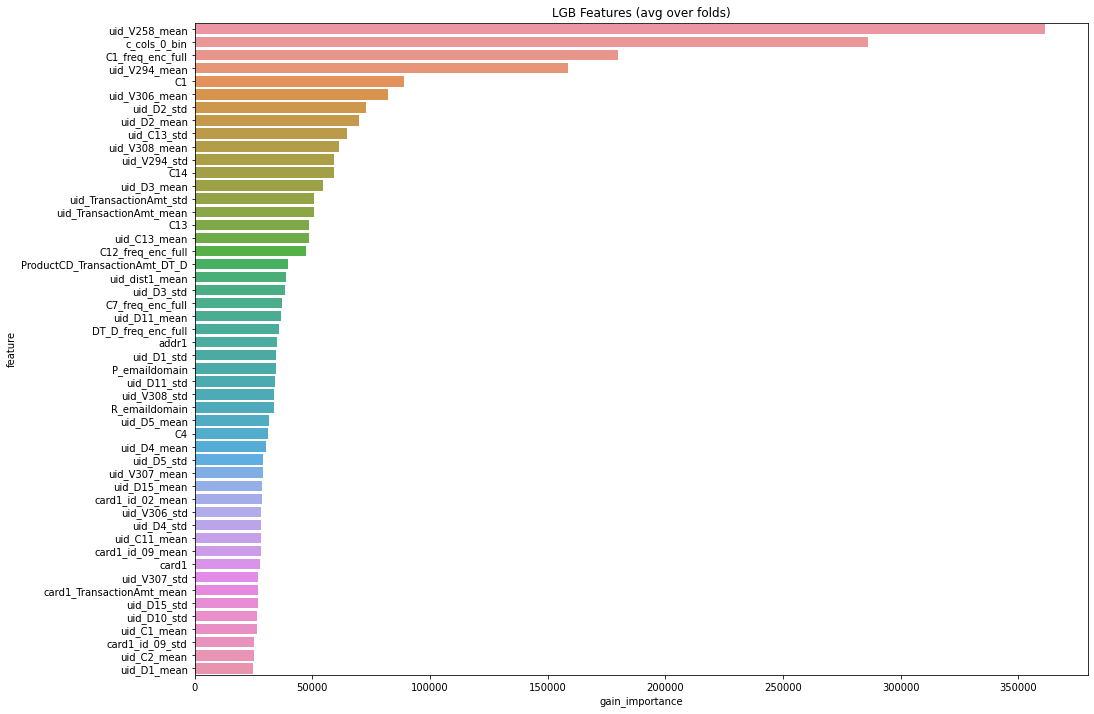

In [81]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [82]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_5.csv', index=False)

timeblock frequency encoding: ProductCD_TransactionAmt_DT_D
timeblock frequency encoding: ProductCD_cents_DT_D
timeblock frequency encoding: ProductCD_cents_DT_D
timeblock frequency encoding: uid_DT_D
timeblock frequency encoding: card3_card5_DT_D
timeblock frequency encoding: ProductCD_TransactionAmt_DT_W
timeblock frequency encoding: ProductCD_cents_DT_W
timeblock frequency encoding: ProductCD_cents_DT_W
timeblock frequency encoding: uid_DT_W
timeblock frequency encoding: card3_card5_DT_W
remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_s